## Exploring Language Model Pretraining on IPUs - Full Pretraining in Minutes Using the TinyStories Dataset

TinyStories is a new natural language dataset with constrained vocabulary and training information, making it a valuable resource for researchers who are interested in studying how language models work and what mechanisms they leverage to perform tasks such as writing coherent English text, in-context reasoning, and creative writing. The dataset can be used to train various small language models, which require little resources and time to do full pre-training runs, yet produce fluent and coherent English utterances. 

TinyStories is made up of short stories in the style of fairy tales written using words that a 4-year-old child would usually be able to understand. The dataset was generated by GPT-3.5 and GPT-4 and consists of 2.1 million short stories, each one is only a few sentences long. The stories are about everyday events that a young child might experience, such as going to the park, playing with friends, or learning something new.

The IPU is a great platform to experiment with the TinyStories dataset and to research novel techniques and architectures, due to the IPU's acceleration capability for small models. The IPU relies on very fast SRAM and works at its best when the entire model can fit onto a single Bow-2000 IPU-Machine consisting of four IPUs, connected with fast IPU Links. The smallest model takes as little as 5 minutes of training to become capable of generating coherent sentences. 

The following are sample outputs of using the TinyStories dataset to train different models:

- Off-the-shelf GPT-2 XL 1.5B parameters (off the shelf): **It was a sunny day** in downtown New York. The sidewalks were packed with people on sidewalks and in front of stores and businesses. There weren't a lot of cars running from building to building at this time of night. The nightlife was in full swing. 

- TinyStories model with 5M parameters (5 minutes training on four IPUs): **It was a sunny day** and the sun was shining in the sun. One day, a little girl saw the sunrise and she wanted to go on an adventure. She went to the park and saw a big tree with a big tree. The tree was so pretty and she wanted to climb it. The girl was so excited to see the tree and started to climb it. She climbed up the tree and down the tree and the tree was so happy to have a new friend. The girl was so happy to see the tree and the tree was happy that she had such a beautiful day.


- TinyStories model with 50M parameters (30 minutes training on four IPUs): **It was a sunny day** and the wind was blowing hard. The wind was blowing and the rain was colder than the trees. The little girl was so happy to see the sun and the rain. She ran outside and started to play in the rain. She splashed in the puddles and laughed with joy. The little girl was so happy to have found the perfect place to play. She splashed in the puddles and laughed with joy. The rain had made her feel so happy and free.


- TinyStories model with 220M parameters (4 hours training on four IPUs): **It was a sunny day** and the birds were singing. Suddenly, the sky turned dark and it started to rain. The rain was cold and wet. The little boy was sad because he couldn't play outside. But then, he saw a rainbow in the sky. It was so pretty and colorful. He forgot all about the rain and started to dance in the rain. The rainbow seemed to smile at him. The little boy felt happy again. He knew that even on a rainy day, he could still have fun and enjoy the pretty rainbow in the sky. 


As the examples above show, it is possible to create a model from scratch that is capable of generating English text in less than a day, which unlocks making many research experiments and iteration with language models. In this notebook we will show how to:

* Implement a Transformer model and the training loops for the TinyStories datasets on the IPU
* Choose training parameters interactively
* Sweep hyper parameters for model size
* Evaluate the impact of those hyper parameters on the quality of the model output


For more information about the TinyStories dataset, refer to the paper: [TinyStories: How Small Can Language Models Be and Still Speak Coherent English?](https://arxiv.org/abs/2305.07759).

## Setup

The best way to run this demo is on Paperspace Gradient’s cloud IPUs because everything is already set up for you. To improve your experience, we preload datasets and pre-install packages. This can take a few minutes. If you experience errors immediately after starting a session, please try restarting the kernel before contacting support. If a problem persists or you want to give us feedback on the content of this notebook, please reach out to our community of developers using our [Slack channel](https://www.graphcore.ai/join-community). 

[![Run on Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://ipu.dev/ONUom8)  

To run the demo using other IPU hardware, you need to have the Poplar SDK enabled and a PopTorch wheel installed. Refer to the [PyTorch Quick Start guide](https://docs.graphcore.ai/projects/pytorch-quick-start/) for details on how to do this. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.

In [ ]:
# Download libraries
! pip install datasets matplotlib einops tokenizers wandb pandas

In [3]:
# Imports
%load_ext autoreload
%autoreload 2

import json
import os
import sys
import math
import dataclasses
from IPython import display
from dataclasses import dataclass
from itertools import islice
from typing import *

import torch
import poptorch
from torch import nn, Tensor
import torch.nn.functional as F
import einops

import datasets
import tokenizers

import tqdm
import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [4]:
# Set globals
NUMBER_OF_IPUS = int(os.getenv("NUM_AVAILABLE_IPU", 4))
MODEL_SAVING = True

In [5]:
# List available IPU devices
! gc-monitor

+---------------+---------------------------------------------------------------------------------+
|  gc-monitor   |          Partition: 139544-reconfig [active] has 4 reconfigurable IPUs          |
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+
|    IPU-M    |       Serial       |IPU-M SW|Server version|  ICU FW  | Type  | ID | IPU# |Routing|
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+
|  10.5.13.8  | 0113.0002.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 0  |  3   |  DNC  |
|  10.5.13.8  | 0113.0002.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 1  |  2   |  DNC  |
|  10.5.13.8  | 0113.0001.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 2  |  1   |  DNC  |
|  10.5.13.8  | 0113.0001.8204521  |...0-028|    1.11.0    |  2.5.9   | M2000 | 3  |  0   |  DNC  |
+-------------+--------------------+--------+--------------+----------+-------+----+------+-------+


## Configuration classes

These configuration classes define all the specifications that we will need to train small language models.

In [6]:
@dataclass
class ModelConfig:
    hidden_size: int
    depth: int
    seq_length: int
    head_size: int

@dataclass
class TrainingConfig:
    lr: float
    steps: int
    batch_size: int
    generation_temperature: float
    wd: float = 0.01
        
@dataclass
class ExecutionConfig:
    dtype: Literal['half', 'float', 'float16', 'float32']
    pipeline_stages: int
    checkpointing: bool
    compute_batch_size: int
    replicas: int
    offloading: bool
    device_iterations: int

@dataclass
class Experiment:
    name: str
    model: ModelConfig
    train: TrainingConfig
    execution: ExecutionConfig
    profiling: bool
    wandb: bool

## Transformer model definition

This section contains all the components that make the Transformer model. In particular:

- an attention block
- a feed-forward block
- a skip connection and a layer normalization that transform the above components into modules
- a transformer layer consisting of two modules
- a model consisting of an embedding, a layer stack and a de-embedding projection

Note: this implementation does not use dropout and uses the [ALiBi](https://arxiv.org/abs/2108.12409) positional encoding scheme.

In [7]:
# Transformer attention module with relative positional encoding
class Attention(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.n_heads = config.hidden_size // config.head_size
        self.qkv = nn.Linear(config.hidden_size, 3 * self.n_heads * config.head_size)
        self.out = nn.Linear(self.n_heads * config.head_size, config.hidden_size)
        self.attention_bias = nn.Parameter(self.gen_attention_bias(), requires_grad=False)
        
    def gen_attention_bias(self) -> Tensor:
        causal_mask = torch.tril(torch.ones((self.config.seq_length, self.config.seq_length), dtype=torch.float16))
        causal_mask = causal_mask.view(1, 1, self.config.seq_length, self.config.seq_length)
        alibi_mask = self.gen_alibi_mask(causal_mask)
        causal_mask = (1.0 - causal_mask) * -10_000
        return alibi_mask + causal_mask
    
    # Based on https://nn.labml.ai/transformers/alibi/index.html
    def gen_alibi_mask(self, causal_mask: Tensor) -> Tensor:
        distances = causal_mask.to(torch.float32).cumsum(dim=-1)
        slopes = self.gen_slopes()
        return distances.to(torch.float16) * slopes.view(1, self.n_heads, 1, 1)
    
    def gen_slopes(self) -> Tensor:
        n = 2 ** math.floor(math.log2(self.n_heads))
        m_0 = 2.0 ** (-8.0 / n)
        m = torch.pow(m_0, torch.arange(1, 1 + n))
        if n < self.n_heads:
            m_hat_0 = 2.0 ** (-4.0 / n)
            m_hat = torch.pow(m_hat_0, torch.arange(1, 1 + 2 * (self.n_heads - n), 2))
            m = torch.cat([m, m_hat])
        return m

    def forward(self, x: Tensor) -> Tensor:
        s = x.shape[1]
        q, k, v = einops.rearrange(
            self.qkv(x), "b s (M n d) -> M b n s d", M=3, n=self.n_heads
        )
        a = torch.einsum("bnsd, bntd -> bnst", q, k) * q.shape[-1] ** -0.5
        a += self.attention_bias[:, :, :s, :s]
        mix = torch.einsum("bnst, bntd -> bnsd", torch.softmax(a, -1), v)
        return self.out(einops.rearrange(mix, "b n s d -> b s (n d)"))

In [8]:
# FFN module with a GeLU non-linearity
class FFN(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.up = nn.Linear(config.hidden_size, 4 * config.hidden_size)
        self.down = nn.Linear(self.up.out_features, self.up.in_features)

    def forward(self, x: Tensor) -> Tensor:
        return self.down(F.gelu(self.up(x)))

In [9]:
# Normalization wrapper with a Pre-Norm configuration
class PreNormResidual(nn.Module):
    def __init__(self, config: ModelConfig, body: nn.Module):
        super().__init__()
        self.norm = nn.LayerNorm([config.hidden_size])
        self.body = body

    def forward(self, x: Tensor) -> Tensor:
        return x + self.body(self.norm(x))

In [10]:
# Transformer layer
class TransformerLayer(nn.Sequential):
    def __init__(self, config: ModelConfig):
        super().__init__(
            PreNormResidual(config, Attention(config)),
            PreNormResidual(config, FFN(config)),
        )

In [11]:
# Full model
class Model(nn.Module):
    def __init__(self, config: ModelConfig, execution: ExecutionConfig, tokenizer: tokenizers.Tokenizer):
        super().__init__()
        
        self.config = config
        self.execution = execution
        self.tokenizer = tokenizer
        
        # Embedding
        self.pre = nn.Sequential(
            nn.Embedding(tokenizer.get_vocab_size(), config.hidden_size),
            nn.LayerNorm([config.hidden_size]),
        )
        # Layer stack
        self.core = nn.Sequential(*(TransformerLayer(config) for _ in range(config.depth)))
        #De-embedding
        self.post = nn.Sequential(
            nn.LayerNorm([config.hidden_size]),
            nn.Linear(config.hidden_size, tokenizer.get_vocab_size()),
        )
        
        # Place embedding layer on IPU 0
        self.pre[0] = poptorch.BeginBlock(self.pre[0], "Token embedding", ipu_id=0)
        
        for i in range(config.depth):
            # Create recomputation checkpoints for all layers
            if execution.checkpointing: self.recomputation_checkpoint(self.core[i])
            # Distribute core layers across IPUs specified in pipeline_stages
            ipu_id = (i * execution.pipeline_stages) // config.depth
            self.core[i] = poptorch.BeginBlock(self.core[i], ipu_id=ipu_id)
        
        # Place de-embedding layer on the last IPU in the pipeline 
        self.post[1] = poptorch.BeginBlock(self.post[1], ipu_id=execution.pipeline_stages - 1)
        
        self.model = nn.Sequential(self.pre, self.core, self.post)
        self.to(getattr(torch, execution.dtype))
        
    @staticmethod
    def recomputation_checkpoint(module: nn.Module) -> torch.utils.hooks.RemovableHandle:
        """Annotates the output of a module to be checkpointed instead of recomputed."""
        def recompute_outputs(_module, _inputs, outputs):
            if isinstance(outputs, torch.Tensor):
                return poptorch.recomputationCheckpoint(outputs)
            elif isinstance(outputs, tuple):
                return tuple(poptorch.recomputationCheckpoint(y) for y in outputs)

        module.register_forward_hook(recompute_outputs)

    def forward(self, indices: Tensor, debug=False) -> Tensor:
        logits = self.model(indices).float()
        return F.cross_entropy(logits[:, :-1, :].flatten(0, -2), indices[:, 1:].flatten())

    def generate(self, prompt: str, count: int, temperature: float) -> str:
        prompt_ids = self.tokenizer.encode(prompt).ids
        completion_ids = []
        for _ in range(count):
            logits = self.model(torch.tensor(prompt_ids + completion_ids)[None])[0, -1]
            sample = torch.argmax(
                logits + temperature * torch.log(-torch.log(torch.rand_like(logits)))
            )
            print(self.tokenizer.decode(prompt_ids + completion_ids), end="\r")
            completion_ids.append(int(sample))
        print("\n")
        return self.tokenizer.decode(completion_ids)

## Data pipeline

This data pipeline pre-processes, saves, and batches the data. It does not divide data by samples, but starts reading a sample midway through the sentence. This works faster for pre-training than the traditional separation and because of relative positional embedding trains just as well. 

In [12]:
@dataclass
class Dataset:
    data: Dict[str, Tensor]
    tokenizer: tokenizers.Tokenizer

    def batches(
        self, seq_length: int, batch_size: int, split: str
    ) -> Iterable[Tensor]:
        tokens = self.data[split]
        while True:
            offsets = torch.randint(
                0, len(tokens) - seq_length, size=(batch_size,)
            )
            yield torch.stack([tokens[i : i + seq_length].long() for i in offsets])

    @classmethod
    def create(cls, vocab_size: int, path: Path) -> "Dataset":
        if not (path / "tokenizer.json").exists() or not (path / "data.pt").exists():
            path.mkdir(exist_ok=True, parents=True)
            original_data = datasets.load_dataset("roneneldan/TinyStories")
            tokenizer = tokenizers.Tokenizer(
                tokenizers.models.BPE(end_of_word_suffix="</w>")
            )
            tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.WhitespaceSplit()
            tokenizer.decoder = tokenizers.decoders.BPEDecoder(
                suffix=tokenizer.model.end_of_word_suffix
            )
            tokenizer.train_from_iterator(
                original_data["train"][: 100_000]["text"],
                tokenizers.trainers.BpeTrainer(
                    vocab_size=vocab_size,
                    limit_alphabet=512,
                    special_tokens=["<pad>", "</s>"],
                    end_of_word_suffix=tokenizer.model.end_of_word_suffix,
                    show_progress=False,
                ),
            )
            tokenizer.save(str(path / "tokenizer.json"))
            torch.save(
                {
                    name: torch.tensor(
                        [
                            token
                            for batch in tqdm.tqdm(
                                split.iter(1000),
                                total=len(split) // 1000,
                                desc=f"generating {name}",
                            )
                            for seq in tokenizer.encode_batch(batch["text"])
                            for token in [tokenizer.token_to_id("</s>")] + seq.ids
                        ],
                        dtype=torch.int16,
                    )
                    for name, split in original_data.items()
                },
                path / "data.pt",
            )
        return cls(
            data=torch.load(path / "data.pt"),
            tokenizer=tokenizers.Tokenizer.from_file(str(path / "tokenizer.json")),
        )

## Trainer

This trainer object creates an instance of the model and wraps all the training and validation functionality for pre-training and validation. It includes two optional functionalities: 
- Logging model runs with Weights & Biases
- Profiling the IPU model. Profiling can be useful if trying custom configurations and model compilation results in Out of Memory error. See the [Profiling Quick Start guide](https://docs.graphcore.ai/projects/profiling-quick-start/en/latest/index.html) for an overall introduction to profiling on the IPU.

In [13]:
class Trainer:
    
    def __init__(self, experiment: Experiment, dataset: Dataset):
        self.train_config = tc = experiment.train
        self.model_config = mc = experiment.model
        self.execution_config = ec = experiment.execution
        self.wandb = experiment.wandb
        self.name = experiment.name
        self.dataset = dataset
        
        if experiment.profiling:
            self.set_up_profiling(mc, tc)
        
        torch.seed()
        self.options = self.get_poptorch_options(ec, tc )
        
        
        self.model = Model(mc, ec, dataset.tokenizer)
        self.optimizer = poptorch.optim.AdamW(
            self.model.parameters(), lr=tc.lr, weight_decay=tc.wd, loss_scaling=mc.seq_length, 
        )
        self.host_steps = tc.steps // ec.device_iterations
        self.lr_schedule = torch.optim.lr_scheduler.LinearLR(self.optimizer, 1, 0, total_iters=self.host_steps)
        self.poptorch_trainer = poptorch.trainingModel(self.model, self.options, self.optimizer)
        
        if self.wandb:
            self.set_up_wandb(experiment)
        
    @staticmethod
    def set_up_profiling(model_config: ModelConfig, train_config: TrainingConfig):
        """Enable memory profiling on IPU"""
        out = Path(os.getenv("PROFILE_DIR","profiles/latest"))
        out.mkdir(exist_ok=True, parents=True)
        os.environ["POPLAR_ENGINE_OPTIONS"] = json.dumps(
            {
                "autoReport.outputGraphProfile": True,
                "autoReport.directory": str(out),
                "autoReport.outputArchive": True,
                "debug.outputAllSymbols": True,
            }
        )
        (out / "app.json").write_text(
            json.dumps(dict(model=model_config.__dict__, training=train_config.__dict__))
        )     

    @staticmethod
    def get_poptorch_options(execution_config: ExecutionConfig, train_config: TrainingConfig) -> poptorch.Options:
        """Configure poptorch options to run the model on IPU"""
        options = poptorch.Options()
        options.output_mode = poptorch.OutputMode.Sum
        options.device_iterations = execution_config.device_iterations
        options.replication_factor = execution_config.replicas
        options.Training.gradient_accumulation = (
            train_config.batch_size // execution_config.replicas // execution_config.compute_batch_size
        )
        options.Precision.setPartialsType(torch.half)
        options.Precision.enableFloatingPointExceptions(True)
        
        if execution_config.offloading:
            proportions = {f"IPU{ipu}": 0.4 for ipu in range(execution_config.pipeline_stages)}
            options.setAvailableMemoryProportion(proportions)
            options.TensorLocations.setOptimizerLocation(
                poptorch.TensorLocationSettings().useOnChipStorage(False))
        
        return options
    
    def set_up_wandb(self, experiment: Experiment)-> None:
        """Configure Weights & Biases logging"""
        os.environ["WANDB_SILENT"] = "true"
        os.environ["WANDB_DIR"] = "/tmp/wandb"
        Path("/tmp/wandb").mkdir(exist_ok=True)
        wandb.init(
            project="tinystories",
            config=dict(**dataclasses.asdict(experiment)),
            reinit=True,
        )
        wandb.summary["n_parameters"] = sum(p.nelement() for p in self.model.parameters())
    
    def summary(self) -> None:
        """Model summary"""
        print(
            f"Running: {self.name}"
            f"\n{self.train_config}\n{self.model_config}\n{self.execution_config}"
            f"\n({sum(p.nelement() for p in self.model.parameters())/1e6:.1f} million parameters)\n",
            file=sys.stderr,
        )
        
    def _core_model_loop(self) -> Iterable[Tensor]:
        """This function creates a generator for iterating over batches and passing them
        through the model to get the loss"""
        batches = self.dataset.batches(
            self.model_config.seq_length,
            self.execution_config.device_iterations * self.train_config.batch_size,
            "train",
        )
        for host_step, batch in enumerate(islice(batches, self.host_steps)):
            self.poptorch_trainer.setOptimizer(self.optimizer)
            loss = (
                self.poptorch_trainer(batch).sum()
                * self.execution_config.compute_batch_size
                / (self.train_config.batch_size * self.execution_config.device_iterations)
            )
            self.lr_schedule.step()
            yield host_step * self.execution_config.device_iterations, float(loss)

            
    def _train_generator(self):
        """Top level generator that runs the steps indicated by the user"""
        it = iter(self._core_model_loop())
        yield next(it)  # compile (before tqdm)
        yield from tqdm.tqdm(
            it, initial=1, total=self.host_steps, desc="training", ncols=120
        )
            
    def train(self, online_plot: bool):
        """This function runs the training of the model and logs the progress either 
        using W&B and/or matplotlib plot"""
        training_loss = []
        try:
            colour = col = np.random.rand(3)

            if online_plot:
                fig, ax = plt.subplots(figsize=(8,8))

            for step, loss in self._train_generator():
                training_loss.append(loss)

                if self.wandb:
                    wandb.log(dict(loss=loss), step=step)
                if online_plot:
                    di = self.execution_config.device_iterations
                    ax.plot(np.arange(0,len(training_loss)*di,di),training_loss, c=colour)
                    ax.set(xlabel='Steps', ylabel='Training loss',
                           title='Small Language Model trained on TinyStories')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())

            if online_plot:
                display.clear_output(wait=True)
        finally:
            self.poptorch_trainer.destroy() # this detatches the trainer from IPUs
        return training_loss
            
    def validate(self):
        torch.manual_seed(2937852)
        valid_batches = islice(
            self.dataset.batches(self.model.config.seq_length, 64, "validation"), 32
        )
        with torch.no_grad():
            self.validation_loss = float(
                torch.mean(torch.stack(list(map(self.model, valid_batches))))
            )
        if experiment.wandb:
            wandb.log(dict(validation_loss=self.validation_loss), step=self.host_steps)
            
    def run(self, validation: bool, online_plot: bool):
        self.training_loss = self.train(online_plot)
        self.model.float()
        self.model.train(False)
        if validation:
            self.validate()
            print(f"Validation loss: {self.validation_loss}")

## First model run

Let us run one very small model and look at the results that it produces. We will choose the smallest configuration with a hidden size of 64 and a handful of layers. This model does not require any advanced memory optimizations and can be trained in a matter of minutes on the IPU. 

In [14]:
# First define the dataset
dataset = Dataset.create(vocab_size=8192, path=Path("data"))

In [15]:
# Get one experiment going
experiment =  Experiment(
        "First trial run",
        ModelConfig(
            hidden_size=64, # smallest hidden size from the paper 
            depth=4, # few layers deep
            seq_length=512, # seq length from the paper
            head_size=64, # one attention head
        ),
        TrainingConfig(
            lr=3e-4, 
            steps=int(20_000), 
            batch_size=128,
            generation_temperature=0.5
        ),
        ExecutionConfig(
            dtype="half", # using fp16
            pipeline_stages=1, # only use one chip for model
            checkpointing=False, # no checkpointing needed
            compute_batch_size=1, # compute batch size of 1
            replicas=NUMBER_OF_IPUS, # data parallelism over 4/16 chips
            offloading=False, # no offloading needed
            device_iterations=100, 
        ),
        profiling=False, 
        wandb=False,
    )

Validation loss: 3.6649527549743652


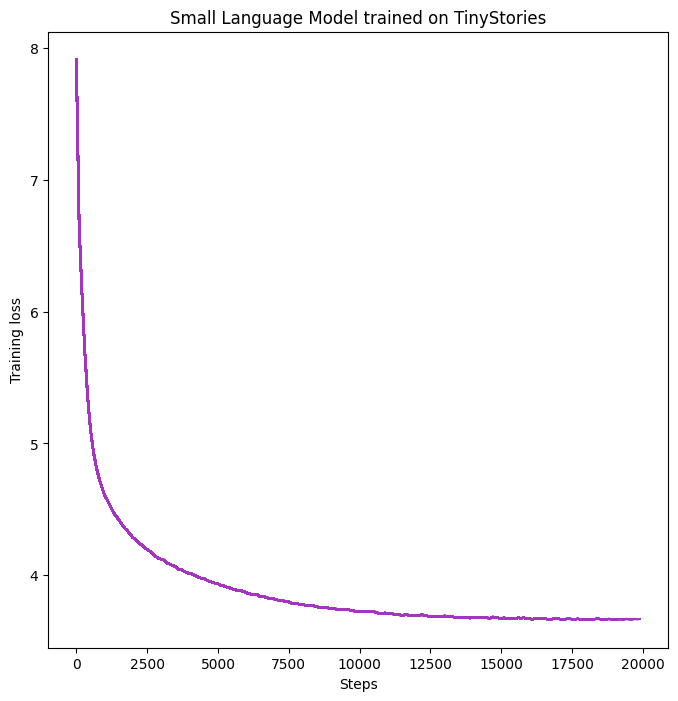

In [14]:
# Initialize trainer and perform the training
trainer = Trainer(experiment, dataset)
trainer.summary()
trainer.run(validation=True, online_plot=True)

In [15]:
# Get the model to generate an output
_ = trainer.model.generate("It was a sunny day", 150, 0.5)

It was a sunny day the little girl was so happy and thanked the little girl and she went to the park and her mom and her mom was so excited to see what she was doing. She had been so much fun and she was so happy that she had been able to have a special day she had been so much fun and she had a lot of fun playing with her friends and she was so happy that she had found a great time to go home. Once upon a time there was a little girl called Lucy. She was very excited to go to the park and explore the world around the world. She was so excited to see the world. One day she saw a big tree and wanted to go on the beach. It was so excited and she decided to go on her mom to the



## Hyperparameter settings

The above model is able to produce some vaguely coherent output, but it is too small to make sense. Creating a larger configuration below allows us to train a larger model or run a sweep. Here we specify the run configurations of the model that we want to train, that determine the shapes of model components and the overall model size. All configurations below are taken from the TinyStories papers and are optimized for throughput on the IPUs. Additional configurations can be defined manually as well, although it's recommended not to deviate too far from the specified proportions below to avoid Out of Memory errors.
Below we specify six components of the model:
- Hidden size
- Depth (number of layers)

Additionally to accommodate the model on the IPUs we choose the following options that do not determine the size of the model, but allow it to fit onto the accelerators. Parameters that optimize the model execution are:

- [Pipeline stages](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/overview.html#pipelined-execution)
- [Compute batch size](https://docs.graphcore.ai/projects/ipu-overview/en/latest/algorithmic_techniques.html#gradient-accumulation)
- [Optimizer state offloading](https://docs.graphcore.ai/projects/poptorch-user-guide/en/1.0.0/overview.html#poptorch.options._TensorLocationOptions.setOptimizerLocation)
- [Recomputation checkpointing](https://docs.graphcore.ai/projects/ipu-overview/en/latest/algorithmic_techniques.html#recomputation)

In [19]:
columns = ['hidden_dim', 'depth', 'pipeline_stages', 'compute_batch_size', 'offloading', 'checkpointing'] 

### EITHER Sweep

If you want to train a whole range on models, then click on the cell below.

In [ ]:
data = [
    [64, 1, 1, 4, False, False],
    [64, 2, 1, 4, False, False],
    [64, 4, 1, 4, False, False],
    [64, 8, 1, 4, False, False],
    [64, 12, 1, 4, False, False],
    [128, 1, 1, 4, False, False],
    [128, 2, 1, 4, False, False],
    [128, 4, 1, 4, False, False],
    [128, 8, 1, 4, False, False],
    [128, 12, 1, 4, False, False],
    [256, 1, 1, 4, False, False],
    [256, 2, 1, 4, False, False],
    [256, 4, 1, 4, False, False],
    [256, 8, 2, 4, False, True],
    [256, 12, 2, 4, False, True],
    [512, 1, 2, 2, False, True],
    [512, 2, 2, 2, False, True],
    [512, 4, 2, 2, False, True],
    [512, 8, 2, 2, False, True],
    [512, 12, 2, 2, False, True],
    [768, 1, 2, 2, False, False],
    [768, 2, 2, 2, False, True],
    [768, 4, 4, 2, False, True],
    [768, 8, 4, 2, False, True],
    [768, 12, 4, 2, True, True],
    [1024, 1, 2, 2, False, False],
    [1024, 2, 2, 1, False, True],
    [1024, 4, 4, 1, False, True],
    [1024, 8, 4, 1, True, True],
    [1024, 12, 4, 1, True, True],
]

# Create a DataFrame
run_configs = pd.DataFrame(data, columns=columns)

### OR Single run

When using a single config, which you can select from the cell below, make sure not to deviate too far from the configurations defined above in the sweep table as these produce optimized training on the IPU. If you want to explore different settings, then also turn on profiling in the training loop, just in case the model goes out of memory. 

In [42]:
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython import display
import ipywidgets as widgets

def hyperparameters(hidden_dim, depth, pipeline_stages, compute_batch_size, offloading, checkpointing):
    return [int(hidden_dim), int(depth), int(pipeline_stages), int(compute_batch_size), offloading, checkpointing]

if 'interactive_data' not in globals():
    hd, depth, ps, cbs,offloading,checkpointing = '256', '8', 4, 2, False, True
else:
    hd, depth, ps, cbs,offloading,checkpointing = interactive_data.result
    hd = str(hd)
    depth = str(depth)
    

interactive_data = interactive(hyperparameters, 
                          hidden_dim=widgets.Dropdown(options=['64', '128', '256','512', '768','1024'], layout={'description_width': '1pt'}, 
                                                      value=hd, description='Hidden dim:', disabled=False),
                          depth=widgets.Dropdown(options=['1', '2', '4','8', '12'], 
                                                      value=depth, description='Depth:', disabled=False), 
                          pipeline_stages=widgets.IntSlider(value=ps, min=1, max=4,step=1, 
                                                            description='Pipeline:',disabled=False), 
                          compute_batch_size=widgets.IntSlider(value=cbs, min=1, max=8,step=1, 
                                                            description='Batch size:',disabled=False), 
                          offloading=offloading, 
                          checkpointing=checkpointing)

display.display(interactive_data)
run_configs = pd.DataFrame([interactive_data.result], columns=columns)

interactive(children=(Dropdown(description='Hidden dim:', index=1, options=('64', '128', '256', '512', '768', …

## Training loop

This code runs training of the chosen model(s) on TinyStories and saves the final checkpoints. 

Validation loss: 1.6554224491119385


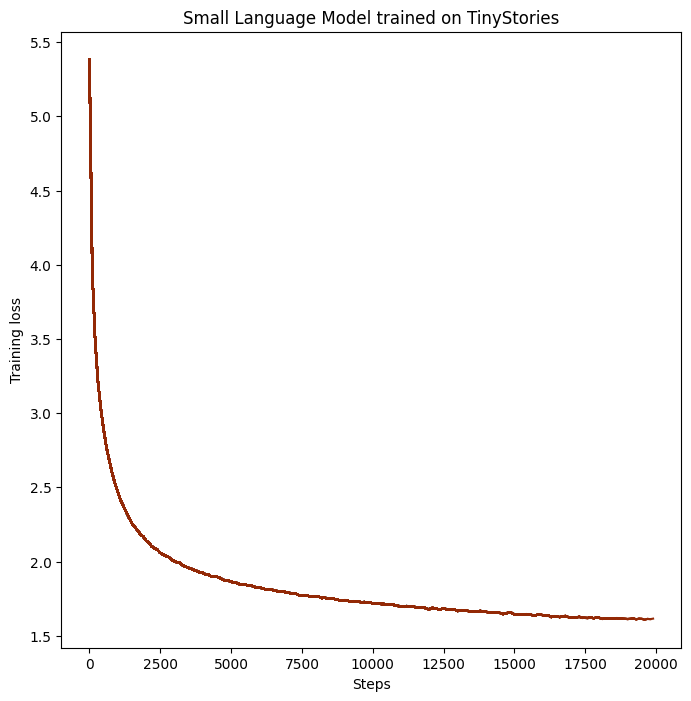

In [34]:
dataset = Dataset.create(vocab_size=8192, path=Path("data"))

for _, run_config in  run_configs.iterrows():
    hidden_size, depth, pipeline_stages, compute_batch_size, offloading, checkpointing = run_config
    
    name =  f"h{hidden_size}_l{depth}_model"
    experiment =  Experiment(
        name,
        ModelConfig(hidden_size=hidden_size, depth=depth, seq_length=512, head_size=64),
        TrainingConfig(lr=3e-4, steps=int(20_000), batch_size=128, generation_temperature=0.5),
        ExecutionConfig(dtype="half", pipeline_stages=pipeline_stages, checkpointing=checkpointing,
                    compute_batch_size=compute_batch_size, replicas=NUMBER_OF_IPUS//pipeline_stages, 
                    offloading=offloading, device_iterations=100),   
        profiling=False,
        wandb=False,
    )

    trainer = Trainer(experiment, dataset)
    trainer.summary()
    trainer.run(validation=True, online_plot=True)
        
    if MODEL_SAVING:
        os.makedirs('checkpoints',exist_ok=True)
        torch.save(trainer.model.state_dict(), os.path.join('checkpoints',name))

## Model generations

A few sample utterances with a pre-trained model. 

In [37]:
TEST_PROMPTS = [
    "</s>",
    "When Sally woke up, she",
    "When I grow up, I",
    "It was a sunny day",
    """Once upon a time there was a little girl named Lucy. She was very adventurous.
She loved to explore the world around her, especially when it was bright and sunny outside.
One day, while exploring the nearby park, Lucy came across a ladder leaning on a wall.
She was curious to see what's on top, so she climbed the ladder, but when she reached the top, the ladder fell and she was stuck.
A nearby park ranger noticed her and shouted out \"""",
]

In [38]:
generations = [
                (
                    prompt,
                    trainer.model.generate(
                        prompt, 150, experiment.train.generation_temperature
                    ),
                )
                for prompt in TEST_PROMPTS
            ]

Once upon a time there was a girl named Lucy. She was three years old and loved to play with her toys. One day, Lucy wanted to play with her toy car but it wouldn't move. She looked around and saw a big box with a lock on it. She asked her mom if she could unlock it. Her mom said yes and gave her a key. Lucy put the key in the lock and turned it. The box opened and Lucy was so excited! Inside the box was a big surprise. It was a new toy car! Lucy was so happy and she thanked her mom for the surprise. She quickly ran to the car and started to play with it. She drove it around the house and made engine noises. Lucy was so happy that she had a new toy to play with. She thanked her

When Sally woke up, she was very hungry. She went to the kitchen and saw her mom making breakfast. Her mom had made pancakes and syrup, which was Sally's favorite. Sally was so happy to have her favorite breakfast. She ate all of the pancakes and syrup, and then she went outside to play. She ran around the gard

## Conclusion

In this notebook, we have: 
* Implemented a Transformer model and the training loops for the TinyStories datasets on the IPU
* Chosen training parameters interactively
* Swept hyperparameters for model size
* Evaluated the impact of those hyperparameters on the quality of the model output

Try out the other [IPU-powered Jupyter Notebooks](https://www.graphcore.ai/ipu-jupyter-notebooks) to see how IPUs perform on other tasks. If you experience problems running this notebook, or you want to give us feedback on the content of this notebook, please reach out to through our community of developers using our [Slack channel](https://www.graphcore.ai/join-community).